# Recomendación para datos de compra, con Tipo de Producto

## La meta

Al resolver estos problemas, crearemos modelos de filtrado colaborativos para recomendar productos a los clientes utilizando datos de compra. En particular, cubriremos en detalle el proceso paso a paso en la construcción de un sistema de recomendación con Python y el módulo de aprendizaje automático Turicreate. Estos pasos incluyen:

#### Transformando y normalizando datos

#### Modelos de entrenamiento

#### Evaluación del desempeño del modelo

#### Seleccionando el modelo óptimo

#### Descripción del producto

La herramienta también podrá buscar una lista de recomendaciones basada en un usuario específico, de modo que:

#### Entrada: ID del cliente

#### Devoluciones: lista clasificada de artículos (ID de producto), que es más probable que el usuario quiera poner en su "cesta" (vacía)


## 1. Obtención de librerías necesarias

In [0]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import time
import turicreate as tc
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

import sys
sys.path.append("..")

## 2. Obtención de los datos

In [0]:
#Usaremos los datos de los clientes que repiten compras a lo largo del año analizado
data = pd.read_csv('DataTypo.csv')
#Elimino la columna Unnamed: 0
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
data.shape

(246858, 3)

## 3. Preparacion de Datos

Nuestro objetivo aquí es dividir cada lista de artículos en la columna de productos en filas y contar la cantidad de productos comprados por un usuario

### 3.1. Crear datos con usuario, elemento y campo de destino.

Chequeo si los datos importados llegan de acuerdo como lo pide el modelo usado.

Se adecuo en el notebook de preparacion de datos. Esta tabla será una entrada para nuestro modelado posterior

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246858 entries, 0 to 246857
Data columns (total 3 columns):
customerId        246858 non-null int64
productId         246858 non-null object
purchase_count    246858 non-null int64
dtypes: int64(2), object(1)
memory usage: 5.7+ MB


In [5]:
data.sample(5)

,customerId,productId,purchase_count
225190,127041,Toallas y Toallones,1
191291,93247,Acolchados y Frazadas,1
25494,8055,Toallas y Toallones,1
150494,64596,Mantelería,1
222860,124329,Toallas y Toallones,1


In [6]:
#Sobre el Dataframe creado, generamos un subdataframe con los códigos de clientes:
customers = pd.DataFrame(data['customerId'].unique(), columns=['user_id'])
customers.sample(5)

,user_id
21710,64358
30654,102849
16426,45849
15010,41245
38777,156737


### 3.2. Crear dummy

¿Por qué crear un dummy en lugar de normalizarlo? Normalizar el recuento de compras, por ejemplo, por cada usuario, no funcionaría porque los clientes pueden tener diferentes frecuencias de compra y no tienen el mismo gusto. Sin embargo, podemos normalizar los artículos por frecuencia de compra en todos los usuarios, lo que se hace en la sección 3.3. 

In [0]:
def create_data_dummy(data):
    data_dummy = data.copy()
    data_dummy['purchase_dummy'] = 1
    return data_dummy

In [0]:
data_dummy = create_data_dummy(data)

### 3.3. Normalizar los items entre los usuarios

In [9]:
# Para hacer esto, normalizamos la frecuencia de compra de cada artículo entre los usuarios creando primero un artículo
# de usuario matriz de la siguiente manera
df_matrix = pd.pivot_table(data, values='purchase_count', index='customerId', columns='productId')
print(df_matrix.shape)
df_matrix.sample(5)

(39037, 27)


productId,Accesorios,Acolchados y Frazadas,Adornos,Alfombras,Almohadas,Almohadones,Aromatizadores,Bandejas,Bebé,Cajas y Cajones,Cama,Cortinas,Guardado,Jabones y Jaboneras,Jardín,Lonas,Mantelería,Muebles,Para Dormir,Para Trabajo,Para Uso,Placard,Sillas,Sábanas,Toallas y Toallones,Vajilla,Velas
customerId,,,,,,,,,,,,,,,,,,,,,,,,,,,
98550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,1.0,NaN,NaN,NaN
28419,NaN,1.0,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.75,NaN,NaN
80683,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
96841,NaN,NaN,NaN,NaN,1.0,1.666667,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.00,NaN,NaN


In [10]:
df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max()-df_matrix.min())
print(df_matrix_norm.shape)
df_matrix_norm.sample(5)

(39037, 27)


productId,Accesorios,Acolchados y Frazadas,Adornos,Alfombras,Almohadas,Almohadones,Aromatizadores,Bandejas,Bebé,Cajas y Cajones,Cama,Cortinas,Guardado,Jabones y Jaboneras,Jardín,Lonas,Mantelería,Muebles,Para Dormir,Para Trabajo,Para Uso,Placard,Sillas,Sábanas,Toallas y Toallones,Vajilla,Velas
customerId,,,,,,,,,,,,,,,,,,,,,,,,,,,
21226,NaN,0.0,NaN,0.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
68491,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
21523,NaN,0.0,NaN,NaN,NaN,0.027778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
69224,NaN,0.0,NaN,NaN,NaN,0.055556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN


In [11]:
# crear una tabla para ingresar al modelado  
d = df_matrix_norm.reset_index() 
d.index.names = ['scaled_purchase_freq'] 
data_norm = pd.melt(d, id_vars=['customerId'], value_name='scaled_purchase_freq').dropna()
print(data_norm.shape)
data_norm.head()

(118807, 3)


,customerId,productId,scaled_purchase_freq
14,37,Accesorios,0.0
29,83,Accesorios,0.0
30,85,Accesorios,0.0
41,124,Accesorios,0.0
51,153,Accesorios,0.0


In [0]:
# Los pasos anteriores se pueden combinar con una función definida a continuación:
def normalize_data(data):
    df_matrix = pd.pivot_table(data, values='purchase_count', index='customerId', columns='productId')
    df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max()-df_matrix.min())
    d = df_matrix_norm.reset_index()
    d.index.names = ['scaled_purchase_freq']
    return pd.melt(d, id_vars=['customerId'], value_name='scaled_purchase_freq').dropna()
# En este paso, hemos normalizado su historial de compras, de 0 a 1 (donde 1 es la mayor cantidad de compras para 
# un artículo y 0 es 0 recuento de compras para ese artículo).

## 4. Split train and test set

Dividir los datos en conjuntos de entrenamiento y prueba es una parte importante de la evaluación del modelado predictivo, en este caso un modelo de filtrado colaborativo. Por lo general, utilizamos una porción más grande de los datos para capacitación y una porción más pequeña para pruebas.
Utilizamos la proporción 80:20 para nuestro tamaño de conjunto de prueba de entrenamiento.


In [13]:
train, test = train_test_split(data, test_size = .2)
print(train.shape, test.shape)

(197486, 3) (49372, 3)


In [0]:
def split_data(data):
    '''
    Divide el conjunto de datos en el conjunto de entrenamiento y prueba..
    
    Args:
        data (pandas.DataFrame)
        
    Returns
        train_data (tc.SFrame)
        test_data (tc.SFrame)
    '''
    train, test = train_test_split(data, test_size = .2)
    train_data = tc.SFrame(train)
    test_data = tc.SFrame(test)
    return train_data, test_data

In [0]:
# Ahora que tenemos tres conjuntos de datos con recuentos de compras, ficticios de compra y recuentos de compras
# a escala, nos gustaría dividir cada uno para modelar.
train_data, test_data = split_data(data)
train_data_dummy, test_data_dummy = split_data(data_dummy)
train_data_norm, test_data_norm = split_data(data_norm)

## 5. Definir modelos usando la biblioteca Turicreate

Antes de ejecutar un enfoque más complicado, como el filtrado colaborativo, debemos ejecutar un modelo de referencia para comparar y evaluar modelos. Dado que la línea de base generalmente usa un enfoque muy simple, las técnicas utilizadas más allá de este enfoque deben elegirse si muestran una precisión y complejidad relativamente mejores. En este caso, utilizaremos el modelo de popularidad.

In [0]:
# variables constantes para definir nombres de campo incluyen:
user_id = 'customerId'
item_id = 'productId'
users_to_recommend = list(data.customerId.unique())
n_rec = 10 # número de artículos para recomendar
n_display = 30 # para mostrar las primeras filas en un conjunto de datos de salida

In [0]:
def model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display):
    if name == 'popularity':
        model = tc.popularity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target)
    elif name == 'cosine':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='cosine')
    elif name == 'pearson':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='pearson')
    recom = model.recommend(users=users_to_recommend, k=n_rec)
    recom.print_rows(n_display)
    return model

## 6. Modelo de popularidad como línea de base

El modelo de popularidad toma los artículos más populares como recomendación. Estos artículos son productos con el mayor número de ventas entre clientes.

In [18]:
# i. Usando el conteo de compras
name = 'popularity'
target = 'purchase_count'
popularity = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
popularity

Preparing data set.

Data has 197486 observations with 39015 users and 27 items.

Data prepared in: 0.287665s

197486 observations to process; with 27 unique items.

recommendations finished on 1000/39037 queries. users per second: 157257

recommendations finished on 2000/39037 queries. users per second: 157456

recommendations finished on 3000/39037 queries. users per second: 175521

recommendations finished on 4000/39037 queries. users per second: 171123

recommendations finished on 5000/39037 queries. users per second: 180005

recommendations finished on 6000/39037 queries. users per second: 178354

recommendations finished on 7000/39037 queries. users per second: 179847

recommendations finished on 8000/39037 queries. users per second: 178082

recommendations finished on 9000/39037 queries. users per second: 183161

recommendations finished on 10000/39037 queries. users per second: 183227

recommendations finished on 11000/39037 queries. users per second: 185955

recommendations finished on 12000/39037 queries. users per second: 183871

recommendations finished on 13000/39037 queries. users per second: 183538

recommendations finished on 14000/39037 queries. users per second: 179166

recommendations finished on 15000/39037 queries. users per second: 177641

recommendations finished on 16000/39037 queries. users per second: 177450

recommendations finished on 17000/39037 queries. users per second: 174293

recommendations finished on 18000/39037 queries. users per second: 177560

recommendations finished on 19000/39037 queries. users per second: 180047

recommendations finished on 20000/39037 queries. users per second: 177783

recommendations finished on 21000/39037 queries. users per second: 177833

recommendations finished on 22000/39037 queries. users per second: 178901

recommendations finished on 23000/39037 queries. users per second: 178284

recommendations finished on 24000/39037 queries. users per second: 175395

recommendations finished on 25000/39037 queries. users per second: 176061

recommendations finished on 26000/39037 queries. users per second: 171645

recommendations finished on 27000/39037 queries. users per second: 174938

recommendations finished on 28000/39037 queries. users per second: 177969

recommendations finished on 29000/39037 queries. users per second: 177651

recommendations finished on 30000/39037 queries. users per second: 179878

recommendations finished on 31000/39037 queries. users per second: 178873

recommendations finished on 32000/39037 queries. users per second: 181319

recommendations finished on 33000/39037 queries. users per second: 183315

recommendations finished on 34000/39037 queries. users per second: 185686

recommendations finished on 35000/39037 queries. users per second: 187062

recommendations finished on 36000/39037 queries. users per second: 188896

recommendations finished on 37000/39037 queries. users per second: 174777

recommendations finished on 38000/39037 queries. users per second: 175663

recommendations finished on 39000/39037 queries. users per second: 178138

+------------+---------------------+--------------------+------+
| customerId |      productId      |       score        | rank |
+------------+---------------------+--------------------+------+
|     0      |   Cajas y Cajones   | 1.9313186813186813 |  1   |
|     0      |       Muebles       | 1.6529051987767585 |  2   |
|     0      |      Almohadas      | 1.5980458986593955 |  3   |
|     0      |     Almohadones     | 1.484428319982758  |  4   |
|     0      |        Sillas       | 1.3129032258064517 |  5   |
|     0      |      Mantelería     | 1.312883435582822  |  6   |
|     0      |       Placard       | 1.2700822264389626 |  7   |
|     0      |       Cortinas      | 1.201544774318127  |  8   |
|     0      | Jabones y Jaboneras | 1.1692307692307693 |  9   |
|     0      |        Jardín       | 1.1608391608391608 |  10  |
|     2      |   Cajas y Cajones   | 1.9313186813186813 |  1   |
|     2      |       Muebles       | 1.6529051987767585 |  2   |
|     2      |      Almoh

Class                            : PopularityRecommender

Schema
------
User ID                          : customerId
Item ID                          : productId
Target                           : purchase_count
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 197486
Number of users                  : 39015
Number of items                  : 27

Training summary
----------------
Training time                    : 0.0199

Model Parameters
----------------
Model class                      : PopularityRecommender

In [19]:
# ii. Usando el dummy de compras
name = 'popularity'
target = 'purchase_dummy'
pop_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
pop_dummy

Warning: Ignoring columns purchase_count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 197486 observations with 39017 users and 27 items.

Data prepared in: 0.230341s

197486 observations to process; with 27 unique items.

recommendations finished on 1000/39037 queries. users per second: 108660

recommendations finished on 2000/39037 queries. users per second: 127121

recommendations finished on 3000/39037 queries. users per second: 144030

recommendations finished on 4000/39037 queries. users per second: 151435

recommendations finished on 5000/39037 queries. users per second: 154976

recommendations finished on 6000/39037 queries. users per second: 158199

recommendations finished on 7000/39037 queries. users per second: 163403

recommendations finished on 8000/39037 queries. users per second: 165313

recommendations finished on 9000/39037 queries. users per second: 168852

recommendations finished on 10000/39037 queries. users per second: 172061

recommendations finished on 11000/39037 queries. users per second: 173622

recommendations finished on 12000/39037 queries. users per second: 173003

recommendations finished on 13000/39037 queries. users per second: 173336

recommendations finished on 14000/39037 queries. users per second: 174969

recommendations finished on 15000/39037 queries. users per second: 179055

recommendations finished on 16000/39037 queries. users per second: 178037

recommendations finished on 17000/39037 queries. users per second: 180389

recommendations finished on 18000/39037 queries. users per second: 179996

recommendations finished on 19000/39037 queries. users per second: 181051

recommendations finished on 20000/39037 queries. users per second: 182448

recommendations finished on 21000/39037 queries. users per second: 182493

recommendations finished on 22000/39037 queries. users per second: 185872

recommendations finished on 23000/39037 queries. users per second: 185863

recommendations finished on 24000/39037 queries. users per second: 187642

recommendations finished on 25000/39037 queries. users per second: 188338

recommendations finished on 26000/39037 queries. users per second: 188579

recommendations finished on 27000/39037 queries. users per second: 179186

recommendations finished on 28000/39037 queries. users per second: 165703

recommendations finished on 29000/39037 queries. users per second: 164603

recommendations finished on 30000/39037 queries. users per second: 164260

recommendations finished on 31000/39037 queries. users per second: 165210

recommendations finished on 32000/39037 queries. users per second: 166148

recommendations finished on 33000/39037 queries. users per second: 167753

recommendations finished on 34000/39037 queries. users per second: 169218

recommendations finished on 35000/39037 queries. users per second: 171925

recommendations finished on 36000/39037 queries. users per second: 174603

recommendations finished on 37000/39037 queries. users per second: 172809

recommendations finished on 38000/39037 queries. users per second: 170365

recommendations finished on 39000/39037 queries. users per second: 169816

+------------+-----------------------+-------+------+
| customerId |       productId       | score | rank |
+------------+-----------------------+-------+------+
|     0      |         Sillas        |  1.0  |  1   |
|     0      |  Jabones y Jaboneras  |  1.0  |  2   |
|     0      |       Accesorios      |  1.0  |  3   |
|     0      |          Cama         |  1.0  |  4   |
|     0      |        Cortinas       |  1.0  |  5   |
|     0      |       Alfombras       |  1.0  |  6   |
|     0      |       Mantelería      |  1.0  |  7   |
|     0      | Acolchados y Frazadas |  1.0  |  8   |
|     0      |       Almohadas       |  1.0  |  9   |
|     0      |      Almohadones      |  1.0  |  10  |
|     2      |  Jabones y Jaboneras  |  1.0  |  1   |
|     2      |       Accesorios      |  1.0  |  2   |
|     2      |          Cama         |  1.0  |  3   |
|     2      |        Cortinas       |  1.0  |  4   |
|     2      |       Alfombras       |  1.0  |  5   |
|     2      |       Mantele

Class                            : PopularityRecommender

Schema
------
User ID                          : customerId
Item ID                          : productId
Target                           : purchase_dummy
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 197486
Number of users                  : 39017
Number of items                  : 27

Training summary
----------------
Training time                    : 0.0168

Model Parameters
----------------
Model class                      : PopularityRecommender

In [20]:
# iii. Uso del recuento de compras escalado
name = 'popularity'
target = 'scaled_purchase_freq'
pop_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
pop_norm

Preparing data set.

Data has 95045 observations with 37673 users and 27 items.

Data prepared in: 0.131653s

95045 observations to process; with 27 unique items.

recommendations finished on 1000/39037 queries. users per second: 66379

recommendations finished on 2000/39037 queries. users per second: 96739.9

recommendations finished on 3000/39037 queries. users per second: 115300

recommendations finished on 4000/39037 queries. users per second: 130976

recommendations finished on 5000/39037 queries. users per second: 146873

recommendations finished on 6000/39037 queries. users per second: 136249

recommendations finished on 7000/39037 queries. users per second: 134976

recommendations finished on 8000/39037 queries. users per second: 139298

recommendations finished on 9000/39037 queries. users per second: 145681

recommendations finished on 10000/39037 queries. users per second: 149265

recommendations finished on 11000/39037 queries. users per second: 154464

recommendations finished on 12000/39037 queries. users per second: 155328

recommendations finished on 13000/39037 queries. users per second: 158053

recommendations finished on 14000/39037 queries. users per second: 161650

recommendations finished on 15000/39037 queries. users per second: 163607

recommendations finished on 16000/39037 queries. users per second: 165505

recommendations finished on 17000/39037 queries. users per second: 169559

recommendations finished on 18000/39037 queries. users per second: 173114

recommendations finished on 19000/39037 queries. users per second: 169694

recommendations finished on 20000/39037 queries. users per second: 172490

recommendations finished on 21000/39037 queries. users per second: 176662

recommendations finished on 22000/39037 queries. users per second: 170605

recommendations finished on 23000/39037 queries. users per second: 171655

recommendations finished on 24000/39037 queries. users per second: 173824

recommendations finished on 25000/39037 queries. users per second: 174872

recommendations finished on 26000/39037 queries. users per second: 171844

recommendations finished on 27000/39037 queries. users per second: 171596

recommendations finished on 28000/39037 queries. users per second: 172754

recommendations finished on 29000/39037 queries. users per second: 174078

recommendations finished on 30000/39037 queries. users per second: 175931

recommendations finished on 31000/39037 queries. users per second: 174883

recommendations finished on 32000/39037 queries. users per second: 172765

recommendations finished on 33000/39037 queries. users per second: 172600

recommendations finished on 34000/39037 queries. users per second: 173312

recommendations finished on 35000/39037 queries. users per second: 172931

recommendations finished on 36000/39037 queries. users per second: 172406

recommendations finished on 37000/39037 queries. users per second: 172059

recommendations finished on 38000/39037 queries. users per second: 172393

recommendations finished on 39000/39037 queries. users per second: 172498

+------------+---------------------+----------------------+------+
| customerId |      productId      |        score         | rank |
+------------+---------------------+----------------------+------+
|     0      |   Cajas y Cajones   | 0.11754385964912271  |  1   |
|     0      |       Muebles       | 0.07593095130408606  |  2   |
|     0      |        Velas        | 0.07377049180327869  |  3   |
|     0      |      Almohadas      | 0.06645990892695326  |  4   |
|     0      |     Almohadones     | 0.05361869125845879  |  5   |
|     0      |        Sillas       | 0.05103244837758111  |  6   |
|     0      |      Alfombras      | 0.04471881560048608  |  7   |
|     0      |       Vajilla       |         0.04         |  8   |
|     0      | Jabones y Jaboneras | 0.038083333333333344 |  9   |
|     0      |      Mantelería     | 0.034567279542456586 |  10  |
|     2      |   Cajas y Cajones   | 0.11754385964912271  |  1   |
|     2      |       Muebles       | 0.07593095130408606  |  2

Class                            : PopularityRecommender

Schema
------
User ID                          : customerId
Item ID                          : productId
Target                           : scaled_purchase_freq
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 95045
Number of users                  : 37673
Number of items                  : 27

Training summary
----------------
Training time                    : 0.0091

Model Parameters
----------------
Model class                      : PopularityRecommender

### 6.1. Resumen de referencia

Una vez que creamos el modelo, predijimos los ítems de recomendación usando puntajes por popularidad. Como puede ver para los resultados de cada modelo anteriores, las filas muestran los primeros 30 registros de 1000 usuarios con 10 recomendaciones. Estos 30 registros incluyen 3 usuarios y sus elementos recomendados, junto con puntaje y rangos descendentes.
En el resultado, aunque diferentes modelos tienen diferentes listas de recomendaciones, a cada usuario se le recomienda la misma lista de 10 elementos. Esto se debe a que la popularidad se calcula tomando los elementos más populares entre todos los usuarios.


In [21]:
train.groupby('productId')['purchase_count'].mean().sort_values(ascending=False).head(20)

productId
Cajas y Cajones          1.976623
Muebles                  1.630667
Almohadas                1.604447
Almohadones              1.486637
Sillas                   1.347682
Mantelería               1.312388
Placard                  1.261935
Toallas y Toallones      1.217899
Cortinas                 1.201928
Jabones y Jaboneras      1.185644
Alfombras                1.160571
Jardín                   1.150000
Aromatizadores           1.131490
Para Trabajo             1.120930
Adornos                  1.117708
Velas                    1.100000
Cama                     1.091594
Accesorios               1.087013
Acolchados y Frazadas    1.085906
Lonas                    1.083676
Name: purchase_count, dtype: float64

## 7. Modelo de filtrado colaborativo

En el filtrado colaborativo, recomendamos artículos basados en cómo usuarios similares compran artículos. Por ejemplo, si el cliente 1 y el cliente 2 compraron artículos similares, p. 1 compró X, Y, Z y 2 compró X, Y, recomendaríamos un artículo Z al cliente 2.

### 7.1. Metodología


Para definir la similitud entre los usuarios, utilizamos los siguientes pasos:
1. Cree una matriz de elementos de usuario, donde los valores de índice representan ID de clientes únicos y los valores de columna representan ID de productos únicos
2. Cree una matriz de similitud de artículo a artículo. La idea es calcular qué tan similar es un producto a otro producto. Hay varias formas de calcular esto. En los pasos 7.2 y 7.3, utilizamos la medida de similitud de coseno o de Pearson, respectivamente.
Para calcular la similitud entre los productos X e Y, observe a todos los clientes que han calificado estos dos artículos. Por ejemplo, tanto X como Y han sido calificadas por los clientes 1 y 2.
Luego creamos dos ítems-vectores, v1 para el ítem X y v2 para el ítem Y, en el espacio de usuario de (1, 2) y luego encontramos el coseno o el ángulo / distancia de Pearson entre estos vectores. Un ángulo cero o vectores superpuestos con un valor de coseno de 1 significa similitud total (o por usuario, en todos los elementos, hay la misma calificación) y un ángulo de 90 grados significaría un coseno de 0 o ninguna similitud.
3. Para cada cliente, predecimos su probabilidad de comprar un producto (o su compra cuenta) para productos que no había comprado.
Para nuestro ejemplo, calcularemos la calificación para el usuario 2 en el caso del elemento Z (elemento objetivo). Para calcular esto, sopesamos la medida de similitud calculada entre el artículo objetivo y otros artículos que el cliente ya ha comprado. El factor de ponderación es el recuento de compras otorgado por el usuario a los artículos que ya compró.
Luego escalamos esta suma ponderada con la suma de las medidas de similitud para que la calificación calculada permanezca dentro de límites predefinidos. Por lo tanto, la calificación prevista para el elemento Z para el usuario 2 se calcularía utilizando medidas de similitud.


### 7.2. Similitud de coseno

La similitud es el coseno del ángulo entre los 2 vectores de los vectores ítems de A y B
Se define por la siguiente fórmul
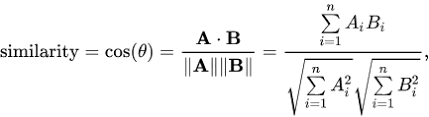

Más cerca de los vectores, más pequeño será el ángulo y más grande el coseno


In [22]:
# i. Usando el conteo de compras
name = 'cosine'
target = 'purchase_count'
cos = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
cos

Preparing data set.

Data has 197486 observations with 39015 users and 27 items.

Data prepared in: 0.213624s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.151ms                        | 2.5        |

| 10.994ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 25.495ms                            | 0                | 0               |

| 47.202ms                            | 100              | 27              |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.074s

recommendations finished on 1000/39037 queries. users per second: 130124

recommendations finished on 2000/39037 queries. users per second: 135373

recommendations finished on 3000/39037 queries. users per second: 145681

recommendations finished on 4000/39037 queries. users per second: 152637

recommendations finished on 5000/39037 queries. users per second: 148624

recommendations finished on 6000/39037 queries. users per second: 148331

recommendations finished on 7000/39037 queries. users per second: 149301

recommendations finished on 8000/39037 queries. users per second: 153536

recommendations finished on 9000/39037 queries. users per second: 152112

recommendations finished on 10000/39037 queries. users per second: 151057

recommendations finished on 11000/39037 queries. users per second: 153312

recommendations finished on 12000/39037 queries. users per second: 154897

recommendations finished on 13000/39037 queries. users per second: 155616

recommendations finished on 14000/39037 queries. users per second: 156530

recommendations finished on 15000/39037 queries. users per second: 156263

recommendations finished on 16000/39037 queries. users per second: 157420

recommendations finished on 17000/39037 queries. users per second: 157572

recommendations finished on 18000/39037 queries. users per second: 151853

recommendations finished on 19000/39037 queries. users per second: 152283

recommendations finished on 20000/39037 queries. users per second: 152922

recommendations finished on 21000/39037 queries. users per second: 154733

recommendations finished on 22000/39037 queries. users per second: 154522

recommendations finished on 23000/39037 queries. users per second: 155136

recommendations finished on 24000/39037 queries. users per second: 154034

recommendations finished on 25000/39037 queries. users per second: 155372

recommendations finished on 26000/39037 queries. users per second: 155599

recommendations finished on 27000/39037 queries. users per second: 155849

recommendations finished on 28000/39037 queries. users per second: 156690

recommendations finished on 29000/39037 queries. users per second: 155564

recommendations finished on 30000/39037 queries. users per second: 153987

recommendations finished on 31000/39037 queries. users per second: 154436

recommendations finished on 32000/39037 queries. users per second: 154769

recommendations finished on 33000/39037 queries. users per second: 152748

recommendations finished on 34000/39037 queries. users per second: 152419

recommendations finished on 35000/39037 queries. users per second: 152222

recommendations finished on 36000/39037 queries. users per second: 152400

recommendations finished on 37000/39037 queries. users per second: 151904

recommendations finished on 38000/39037 queries. users per second: 152094

recommendations finished on 39000/39037 queries. users per second: 151835

+------------+-----------------------+---------------------+------+
| customerId |       productId       |        score        | rank |
+------------+-----------------------+---------------------+------+
|     0      | Acolchados y Frazadas |  0.4666981101036072 |  1   |
|     0      |      Almohadones      |  0.3118313252925873 |  2   |
|     0      |       Mantelería      | 0.25090357661247253 |  3   |
|     0      |       Almohadas       | 0.20607823133468628 |  4   |
|     0      |       Accesorios      | 0.18493062257766724 |  5   |
|     0      |        Cortinas       | 0.17446818947792053 |  6   |
|     0      |          Cama         | 0.17388072609901428 |  7   |
|     0      |        Adornos        | 0.15600067377090454 |  8   |
|     0      |      Para Dormir      | 0.12298816442489624 |  9   |
|     0      |        Muebles        | 0.10421466827392578 |  10  |
|     2      |        Sábanas        |  0.7932891845703125 |  1   |
|     2      | Acolchados y Frazadas |  0.593945

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : customerId
Item ID                          : productId
Target                           : purchase_count
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 197486
Number of users                  : 39015
Number of items                  : 27

Training summary
----------------
Training time                    : 1.0741

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type                  : cosine
training_method                  : auto

Other Settings
--------------
degree_approximation_threshold   : 4096
max_data_passes                  : 4096
max_item_neighborhood_size       : 64
nearest_neighbors_interaction_proportion_threshold : 0.05
seed_item_set_size     

In [23]:
# ii. Usando el dummy de compras
name = 'cosine'
target = 'purchase_dummy'
cos_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
cos_dummy

Warning: Ignoring columns purchase_count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 197486 observations with 39017 users and 27 items.

Data prepared in: 0.236754s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 977us                          | 2.5        |

| 16.711ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 22.363ms                            | 0                | 0               |

| 36.836ms                            | 100              | 27              |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.067381s

recommendations finished on 1000/39037 queries. users per second: 110241

recommendations finished on 2000/39037 queries. users per second: 126863

recommendations finished on 3000/39037 queries. users per second: 137956

recommendations finished on 4000/39037 queries. users per second: 150246

recommendations finished on 5000/39037 queries. users per second: 149027

recommendations finished on 6000/39037 queries. users per second: 147641

recommendations finished on 7000/39037 queries. users per second: 150895

recommendations finished on 8000/39037 queries. users per second: 153944

recommendations finished on 9000/39037 queries. users per second: 153878

recommendations finished on 10000/39037 queries. users per second: 155056

recommendations finished on 11000/39037 queries. users per second: 155339

recommendations finished on 12000/39037 queries. users per second: 156331

recommendations finished on 13000/39037 queries. users per second: 158299

recommendations finished on 14000/39037 queries. users per second: 158176

recommendations finished on 15000/39037 queries. users per second: 159253

recommendations finished on 16000/39037 queries. users per second: 158689

recommendations finished on 17000/39037 queries. users per second: 159476

recommendations finished on 18000/39037 queries. users per second: 150756

recommendations finished on 19000/39037 queries. users per second: 148215

recommendations finished on 20000/39037 queries. users per second: 148588

recommendations finished on 21000/39037 queries. users per second: 148535

recommendations finished on 22000/39037 queries. users per second: 149734

recommendations finished on 23000/39037 queries. users per second: 148271

recommendations finished on 24000/39037 queries. users per second: 149270

recommendations finished on 25000/39037 queries. users per second: 148174

recommendations finished on 26000/39037 queries. users per second: 145342

recommendations finished on 27000/39037 queries. users per second: 143069

recommendations finished on 28000/39037 queries. users per second: 144547

recommendations finished on 29000/39037 queries. users per second: 145426

recommendations finished on 30000/39037 queries. users per second: 146607

recommendations finished on 31000/39037 queries. users per second: 145373

recommendations finished on 32000/39037 queries. users per second: 146236

recommendations finished on 33000/39037 queries. users per second: 146911

recommendations finished on 34000/39037 queries. users per second: 148336

recommendations finished on 35000/39037 queries. users per second: 148829

recommendations finished on 36000/39037 queries. users per second: 149291

recommendations finished on 37000/39037 queries. users per second: 149747

recommendations finished on 38000/39037 queries. users per second: 150690

recommendations finished on 39000/39037 queries. users per second: 150669

+------------+-----------------------+---------------------+------+
| customerId |       productId       |        score        | rank |
+------------+-----------------------+---------------------+------+
|     0      | Acolchados y Frazadas | 0.49516311287879944 |  1   |
|     0      |      Almohadones      | 0.34513360261917114 |  2   |
|     0      |       Mantelería      |  0.3092917501926422 |  3   |
|     0      |       Almohadas       | 0.22382038831710815 |  4   |
|     0      |        Cortinas       |  0.2034805417060852 |  5   |
|     0      |       Accesorios      | 0.19301992654800415 |  6   |
|     0      |          Cama         | 0.17925310134887695 |  7   |
|     0      |        Adornos        |  0.1780984103679657 |  8   |
|     0      |        Muebles        | 0.13453206419944763 |  9   |
|     0      |      Para Dormir      |  0.1290724277496338 |  10  |
|     2      |        Sábanas        |  0.5008598566055298 |  1   |
|     2      | Acolchados y Frazadas |   0.37973

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : customerId
Item ID                          : productId
Target                           : purchase_dummy
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 197486
Number of users                  : 39017
Number of items                  : 27

Training summary
----------------
Training time                    : 0.0674

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type                  : cosine
training_method                  : auto

Other Settings
--------------
degree_approximation_threshold   : 4096
max_data_passes                  : 4096
max_item_neighborhood_size       : 64
nearest_neighbors_interaction_proportion_threshold : 0.05
seed_item_set_size     

In [24]:
# iii. Uso del recuento de compras escalado
name = 'cosine' 
target = 'scaled_purchase_freq' 
cos_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
cos_norm

Preparing data set.

Data has 95045 observations with 37673 users and 27 items.

Data prepared in: 0.131119s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.151ms                        | 2.5        |

| 12.378ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 12.971ms                            | 0                | 0               |

| 26.936ms                            | 100              | 27              |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.040304s

recommendations finished on 1000/39037 queries. users per second: 139082

recommendations finished on 2000/39037 queries. users per second: 140400

recommendations finished on 3000/39037 queries. users per second: 148530

recommendations finished on 4000/39037 queries. users per second: 150995

recommendations finished on 5000/39037 queries. users per second: 151911

recommendations finished on 6000/39037 queries. users per second: 154059

recommendations finished on 7000/39037 queries. users per second: 157441

recommendations finished on 8000/39037 queries. users per second: 159658

recommendations finished on 9000/39037 queries. users per second: 157112

recommendations finished on 10000/39037 queries. users per second: 156890

recommendations finished on 11000/39037 queries. users per second: 156042

recommendations finished on 12000/39037 queries. users per second: 156785

recommendations finished on 13000/39037 queries. users per second: 158657

recommendations finished on 14000/39037 queries. users per second: 159424

recommendations finished on 15000/39037 queries. users per second: 155177

recommendations finished on 16000/39037 queries. users per second: 154306

recommendations finished on 17000/39037 queries. users per second: 153843

recommendations finished on 18000/39037 queries. users per second: 153749

recommendations finished on 19000/39037 queries. users per second: 154017

recommendations finished on 20000/39037 queries. users per second: 151631

recommendations finished on 21000/39037 queries. users per second: 152274

recommendations finished on 22000/39037 queries. users per second: 151967

recommendations finished on 23000/39037 queries. users per second: 151277

recommendations finished on 24000/39037 queries. users per second: 151615

recommendations finished on 25000/39037 queries. users per second: 153233

recommendations finished on 26000/39037 queries. users per second: 153872

recommendations finished on 27000/39037 queries. users per second: 154790

recommendations finished on 28000/39037 queries. users per second: 154845

recommendations finished on 29000/39037 queries. users per second: 155605

recommendations finished on 30000/39037 queries. users per second: 154938

recommendations finished on 31000/39037 queries. users per second: 154175

recommendations finished on 32000/39037 queries. users per second: 153720

recommendations finished on 33000/39037 queries. users per second: 152536

recommendations finished on 34000/39037 queries. users per second: 149646

recommendations finished on 35000/39037 queries. users per second: 149029

recommendations finished on 36000/39037 queries. users per second: 148557

recommendations finished on 37000/39037 queries. users per second: 147997

recommendations finished on 38000/39037 queries. users per second: 148129

recommendations finished on 39000/39037 queries. users per second: 148709

+------------+-----------------------+------------------------+------+
| customerId |       productId       |         score          | rank |
+------------+-----------------------+------------------------+------+
|     0      |          Cama         |          0.0           |  1   |
|     0      |        Para Uso       |          0.0           |  2   |
|     0      |       Mantelería      |          0.0           |  3   |
|     0      |     Aromatizadores    |          0.0           |  4   |
|     0      |        Placard        |          0.0           |  5   |
|     0      |      Para Dormir      |          0.0           |  6   |
|     0      |        Guardado       |          0.0           |  7   |
|     0      |         Lonas         |          0.0           |  8   |
|     0      | Acolchados y Frazadas |          0.0           |  9   |
|     0      |      Almohadones      |          0.0           |  10  |
|     2      |        Sábanas        |  0.01750779151916504   |  1   |
|     

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : customerId
Item ID                          : productId
Target                           : scaled_purchase_freq
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 95045
Number of users                  : 37673
Number of items                  : 27

Training summary
----------------
Training time                    : 0.0404

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type                  : cosine
training_method                  : auto

Other Settings
--------------
degree_approximation_threshold   : 4096
max_data_passes                  : 4096
max_item_neighborhood_size       : 64
nearest_neighbors_interaction_proportion_threshold : 0.05
seed_item_set_size

### 7.3. Pearson similarity

La similitud es el coeficiente de Pearson entre los dos vectores.
Se define por la siguiente fórmula
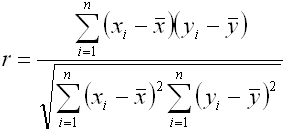

In [25]:
# i. Usando el conteo de compras
name = 'pearson'
target = 'purchase_count'
pear = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
pear

Preparing data set.

Data has 197486 observations with 39015 users and 27 items.

Data prepared in: 0.232159s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.161ms                        | 2.5        |

| 17.668ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 19.622ms                            | 0                | 0               |

| 36.448ms                            | 100              | 27              |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.075626s

recommendations finished on 1000/39037 queries. users per second: 131320

recommendations finished on 2000/39037 queries. users per second: 146274

recommendations finished on 3000/39037 queries. users per second: 150053

recommendations finished on 4000/39037 queries. users per second: 158762

recommendations finished on 5000/39037 queries. users per second: 157139

recommendations finished on 6000/39037 queries. users per second: 161091

recommendations finished on 7000/39037 queries. users per second: 162214

recommendations finished on 8000/39037 queries. users per second: 161878

recommendations finished on 9000/39037 queries. users per second: 162996

recommendations finished on 10000/39037 queries. users per second: 165761

recommendations finished on 11000/39037 queries. users per second: 165635

recommendations finished on 12000/39037 queries. users per second: 166408

recommendations finished on 13000/39037 queries. users per second: 165761

recommendations finished on 14000/39037 queries. users per second: 167204

recommendations finished on 15000/39037 queries. users per second: 164645

recommendations finished on 16000/39037 queries. users per second: 164906

recommendations finished on 17000/39037 queries. users per second: 164997

recommendations finished on 18000/39037 queries. users per second: 166892

recommendations finished on 19000/39037 queries. users per second: 166006

recommendations finished on 20000/39037 queries. users per second: 167311

recommendations finished on 21000/39037 queries. users per second: 167572

recommendations finished on 22000/39037 queries. users per second: 168080

recommendations finished on 23000/39037 queries. users per second: 167145

recommendations finished on 24000/39037 queries. users per second: 168532

recommendations finished on 25000/39037 queries. users per second: 168221

recommendations finished on 26000/39037 queries. users per second: 167103

recommendations finished on 27000/39037 queries. users per second: 167114

recommendations finished on 28000/39037 queries. users per second: 167219

recommendations finished on 29000/39037 queries. users per second: 162031

recommendations finished on 30000/39037 queries. users per second: 159772

recommendations finished on 31000/39037 queries. users per second: 160063

recommendations finished on 32000/39037 queries. users per second: 155320

recommendations finished on 33000/39037 queries. users per second: 149869

recommendations finished on 34000/39037 queries. users per second: 148208

recommendations finished on 35000/39037 queries. users per second: 148181

recommendations finished on 36000/39037 queries. users per second: 147378

recommendations finished on 37000/39037 queries. users per second: 143586

recommendations finished on 38000/39037 queries. users per second: 144386

recommendations finished on 39000/39037 queries. users per second: 144690

+------------+---------------------+--------------------+------+
| customerId |      productId      |       score        | rank |
+------------+---------------------+--------------------+------+
|     0      |   Cajas y Cajones   | 1.8294897135591852 |  1   |
|     0      |       Muebles       | 1.6835220197453264 |  2   |
|     0      |      Almohadas      | 1.5889892754379664 |  3   |
|     0      |     Almohadones     | 1.471116773578947  |  4   |
|     0      |      Mantelería     | 1.298648251849011  |  5   |
|     0      |        Sillas       | 1.265068066153822  |  6   |
|     0      |       Placard       | 1.241813355374248  |  7   |
|     0      |       Cortinas      | 1.1777991313102107 |  8   |
|     0      | Jabones y Jaboneras | 1.1552213117271306 |  9   |
|     0      |      Alfombras      | 1.1431945133536763 |  10  |
|     2      |   Cajas y Cajones   | 1.8295620437956202 |  1   |
|     2      |       Muebles       | 1.697882238985515  |  2   |
|     2      |      Almoh

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : customerId
Item ID                          : productId
Target                           : purchase_count
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 197486
Number of users                  : 39015
Number of items                  : 27

Training summary
----------------
Training time                    : 0.0757

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type                  : pearson
training_method                  : auto

Other Settings
--------------
degree_approximation_threshold   : 4096
max_data_passes                  : 4096
max_item_neighborhood_size       : 64
nearest_neighbors_interaction_proportion_threshold : 0.05
seed_item_set_size    

In [26]:
# ii. Usando el dummy de compras
name = 'pearson'
target = 'purchase_dummy'
pear_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
pear_dummy

Warning: Ignoring columns purchase_count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 197486 observations with 39017 users and 27 items.

Data prepared in: 0.223677s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.153ms                        | 2.5        |

| 15.451ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 15.972ms                            | 0                | 0               |

| 30.631ms                            | 100              | 27              |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.052278s

recommendations finished on 1000/39037 queries. users per second: 108120

recommendations finished on 2000/39037 queries. users per second: 129249

recommendations finished on 3000/39037 queries. users per second: 141483

recommendations finished on 4000/39037 queries. users per second: 153923

recommendations finished on 5000/39037 queries. users per second: 156011

recommendations finished on 6000/39037 queries. users per second: 157134

recommendations finished on 7000/39037 queries. users per second: 160190

recommendations finished on 8000/39037 queries. users per second: 165347

recommendations finished on 9000/39037 queries. users per second: 163657

recommendations finished on 10000/39037 queries. users per second: 165848

recommendations finished on 11000/39037 queries. users per second: 166996

recommendations finished on 12000/39037 queries. users per second: 163546

recommendations finished on 13000/39037 queries. users per second: 166115

recommendations finished on 14000/39037 queries. users per second: 165726

recommendations finished on 15000/39037 queries. users per second: 165420

recommendations finished on 16000/39037 queries. users per second: 164145

recommendations finished on 17000/39037 queries. users per second: 164764

recommendations finished on 18000/39037 queries. users per second: 164950

recommendations finished on 19000/39037 queries. users per second: 165504

recommendations finished on 20000/39037 queries. users per second: 166528

recommendations finished on 21000/39037 queries. users per second: 167171

recommendations finished on 22000/39037 queries. users per second: 164409

recommendations finished on 23000/39037 queries. users per second: 163783

recommendations finished on 24000/39037 queries. users per second: 164527

recommendations finished on 25000/39037 queries. users per second: 164624

recommendations finished on 26000/39037 queries. users per second: 164954

recommendations finished on 27000/39037 queries. users per second: 162977

recommendations finished on 28000/39037 queries. users per second: 152895

recommendations finished on 29000/39037 queries. users per second: 152590

recommendations finished on 30000/39037 queries. users per second: 152184

recommendations finished on 31000/39037 queries. users per second: 153282

recommendations finished on 32000/39037 queries. users per second: 154321

recommendations finished on 33000/39037 queries. users per second: 155756

recommendations finished on 34000/39037 queries. users per second: 155296

recommendations finished on 35000/39037 queries. users per second: 155264

recommendations finished on 36000/39037 queries. users per second: 155303

recommendations finished on 37000/39037 queries. users per second: 156175

recommendations finished on 38000/39037 queries. users per second: 155694

recommendations finished on 39000/39037 queries. users per second: 155871

+------------+-----------------------+-------+------+
| customerId |       productId       | score | rank |
+------------+-----------------------+-------+------+
|     0      |         Sillas        |  0.0  |  1   |
|     0      |  Jabones y Jaboneras  |  0.0  |  2   |
|     0      |       Accesorios      |  0.0  |  3   |
|     0      |          Cama         |  0.0  |  4   |
|     0      |        Cortinas       |  0.0  |  5   |
|     0      |       Alfombras       |  0.0  |  6   |
|     0      |       Mantelería      |  0.0  |  7   |
|     0      | Acolchados y Frazadas |  0.0  |  8   |
|     0      |       Almohadas       |  0.0  |  9   |
|     0      |      Almohadones      |  0.0  |  10  |
|     2      |  Jabones y Jaboneras  |  0.0  |  1   |
|     2      |       Accesorios      |  0.0  |  2   |
|     2      |          Cama         |  0.0  |  3   |
|     2      |        Cortinas       |  0.0  |  4   |
|     2      |       Alfombras       |  0.0  |  5   |
|     2      |       Mantele

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : customerId
Item ID                          : productId
Target                           : purchase_dummy
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 197486
Number of users                  : 39017
Number of items                  : 27

Training summary
----------------
Training time                    : 0.0523

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type                  : pearson
training_method                  : auto

Other Settings
--------------
degree_approximation_threshold   : 4096
max_data_passes                  : 4096
max_item_neighborhood_size       : 64
nearest_neighbors_interaction_proportion_threshold : 0.05
seed_item_set_size    

In [27]:
# iii. Uso del recuento de compras escalado
name = 'pearson'
target = 'scaled_purchase_freq'
pear_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
pear_norm

Preparing data set.

Data has 95045 observations with 37673 users and 27 items.

Data prepared in: 0.134917s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.044ms                        | 2.5        |

| 17.516ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 19.517ms                            | 0                | 0               |

| 35.381ms                            | 100              | 27              |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.055411s

recommendations finished on 1000/39037 queries. users per second: 134989

recommendations finished on 2000/39037 queries. users per second: 134409

recommendations finished on 3000/39037 queries. users per second: 134668

recommendations finished on 4000/39037 queries. users per second: 138313

recommendations finished on 5000/39037 queries. users per second: 136679

recommendations finished on 6000/39037 queries. users per second: 138252

recommendations finished on 7000/39037 queries. users per second: 139718

recommendations finished on 8000/39037 queries. users per second: 141831

recommendations finished on 9000/39037 queries. users per second: 142466

recommendations finished on 10000/39037 queries. users per second: 144071

recommendations finished on 11000/39037 queries. users per second: 142659

recommendations finished on 12000/39037 queries. users per second: 143172

recommendations finished on 13000/39037 queries. users per second: 145151

recommendations finished on 14000/39037 queries. users per second: 145433

recommendations finished on 15000/39037 queries. users per second: 144971

recommendations finished on 16000/39037 queries. users per second: 144013

recommendations finished on 17000/39037 queries. users per second: 145821

recommendations finished on 18000/39037 queries. users per second: 145463

recommendations finished on 19000/39037 queries. users per second: 145979

recommendations finished on 20000/39037 queries. users per second: 146581

recommendations finished on 21000/39037 queries. users per second: 147733

recommendations finished on 22000/39037 queries. users per second: 147215

recommendations finished on 23000/39037 queries. users per second: 147656

recommendations finished on 24000/39037 queries. users per second: 147525

recommendations finished on 25000/39037 queries. users per second: 148750

recommendations finished on 26000/39037 queries. users per second: 149306

recommendations finished on 27000/39037 queries. users per second: 143194

recommendations finished on 28000/39037 queries. users per second: 143081

recommendations finished on 29000/39037 queries. users per second: 143569

recommendations finished on 30000/39037 queries. users per second: 144206

recommendations finished on 31000/39037 queries. users per second: 144996

recommendations finished on 32000/39037 queries. users per second: 146028

recommendations finished on 33000/39037 queries. users per second: 147199

recommendations finished on 34000/39037 queries. users per second: 147726

recommendations finished on 35000/39037 queries. users per second: 148321

recommendations finished on 36000/39037 queries. users per second: 148977

recommendations finished on 37000/39037 queries. users per second: 149903

recommendations finished on 38000/39037 queries. users per second: 150095

recommendations finished on 39000/39037 queries. users per second: 150297

+------------+---------------------+----------------------+------+
| customerId |      productId      |        score         | rank |
+------------+---------------------+----------------------+------+
|     0      |   Cajas y Cajones   | 0.11747400300544598  |  1   |
|     0      |       Muebles       | 0.07561930841887747  |  2   |
|     0      |        Velas        | 0.07375210377036552  |  3   |
|     0      |      Almohadas      |  0.0654900817518117  |  4   |
|     0      |     Almohadones     |  0.0529022434282629  |  5   |
|     0      |        Sillas       | 0.05057784375187922  |  6   |
|     0      |      Alfombras      | 0.04461510351857694  |  7   |
|     0      |       Vajilla       | 0.03974197149276735  |  8   |
|     0      | Jabones y Jaboneras | 0.037833023627599105 |  9   |
|     0      |      Mantelería     | 0.03374753686286049  |  10  |
|     2      |   Cajas y Cajones   | 0.11777119176429608  |  1   |
|     2      |       Muebles       |  0.0769651514955834  |  2

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : customerId
Item ID                          : productId
Target                           : scaled_purchase_freq
Additional observation features  : 0
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 95045
Number of users                  : 37673
Number of items                  : 27

Training summary
----------------
Training time                    : 0.0555

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type                  : pearson
training_method                  : auto

Other Settings
--------------
degree_approximation_threshold   : 4096
max_data_passes                  : 4096
max_item_neighborhood_size       : 64
nearest_neighbors_interaction_proportion_threshold : 0.05
seed_item_set_siz

## 8. Evaluación del modelo

Para evaluar los motores de recomendación, podemos usar el concepto de RMSE y la recuperación de precisión.

1. RMSE (errores cuadráticos medios de raíz)
Mide el error de los valores pronosticados.
Menor el valor RMSE, mejores las recomendaciones.

2. Recordar
 ¿Qué porcentaje de productos que compra un usuario se recomiendan realmente?
Si un cliente compra 5 productos y la recomendación decidió mostrar 3 de ellos, entonces el retiro es 0.6

3. Precisión
De todos los elementos recomendados, ¿cuántos le gustaron realmente al usuario?
Si se recomendaron al cliente 5 productos de los cuales compra 4, entonces la precisión es 0.8
¿Por qué son importantes tanto el recuerdo como la precisión?
Considere un caso en el que recomendamos todos los productos, por lo que nuestros clientes seguramente cubrirán los artículos que les gustaron y compraron. ¡En este caso, tenemos un 100% de retiro! ¿Esto significa que nuestro modelo es bueno?
Tenemos que considerar la precisión. Si recomendamos 300 artículos pero al usuario le gusta y compra solo 3 de ellos, ¡la precisión es del 0.1%! Esta precisión muy baja indica que el modelo no es excelente, a pesar de su excelente recuperación.
Por lo tanto, nuestro objetivo debe ser optimizar tanto el recuerdo como la precisión (para estar lo más cerca posible de 1).

In [0]:
# Primero creemos variables invocables iniciales para la evaluación del modelo:
models_w_counts = [popularity, cos, pear]
models_w_dummy = [pop_dummy, cos_dummy, pear_dummy]
models_w_norm = [pop_norm, cos_norm, pear_norm]

names_w_counts = ['Popularity Model on Purchase Counts', 'Cosine Similarity on Purchase Counts',\
                  'Pearson Similarity on Purchase Counts']
names_w_dummy = ['Popularity Model on Purchase Dummy', 'Cosine Similarity on Purchase Dummy',\
                 'Pearson Similarity on Purchase Dummy']
names_w_norm = ['Popularity Model on Scaled Purchase Counts', 'Cosine Similarity on Scaled Purchase Counts',\
                'Pearson Similarity on Scaled Purchase Counts']

## 8.1. Resultado de evaluación

In [0]:
#### Comparemos todos los modelos que hemos construido basados en RMSE y características de recuperación de precisión:

In [30]:
eval_counts = tc.recommender.util.compare_models(test_data, models_w_counts, model_names=names_w_counts)

PROGRESS: Evaluate model Popularity Model on Purchase Counts


recommendations finished on 1000/27714 queries. users per second: 103199

recommendations finished on 2000/27714 queries. users per second: 96758.6

recommendations finished on 3000/27714 queries. users per second: 105086

recommendations finished on 4000/27714 queries. users per second: 108091

recommendations finished on 5000/27714 queries. users per second: 113585

recommendations finished on 6000/27714 queries. users per second: 113865

recommendations finished on 7000/27714 queries. users per second: 115080

recommendations finished on 8000/27714 queries. users per second: 117706

recommendations finished on 9000/27714 queries. users per second: 120417

recommendations finished on 10000/27714 queries. users per second: 119824

recommendations finished on 11000/27714 queries. users per second: 115522

recommendations finished on 12000/27714 queries. users per second: 115445

recommendations finished on 13000/27714 queries. users per second: 113609

recommendations finished on 14000/27714 queries. users per second: 96899.9

recommendations finished on 15000/27714 queries. users per second: 99435.9

recommendations finished on 16000/27714 queries. users per second: 101082

recommendations finished on 17000/27714 queries. users per second: 103294

recommendations finished on 18000/27714 queries. users per second: 104805

recommendations finished on 19000/27714 queries. users per second: 105121

recommendations finished on 20000/27714 queries. users per second: 106361

recommendations finished on 21000/27714 queries. users per second: 108173

recommendations finished on 22000/27714 queries. users per second: 109255

recommendations finished on 23000/27714 queries. users per second: 110783

recommendations finished on 24000/27714 queries. users per second: 111732

recommendations finished on 25000/27714 queries. users per second: 113105

recommendations finished on 26000/27714 queries. users per second: 113932

recommendations finished on 27000/27714 queries. users per second: 115189


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    | 0.0026340477736883743 | 0.0013252284387811535 |
|   2    |  0.00772172908999059  |   0.0081299117318819  |
|   3    |  0.016934882490197475 |  0.02889377854181155  |
|   4    |  0.02241646821101247  |  0.05061832119334364  |
|   5    |  0.02084866854297471  |  0.05827764896795657  |
|   6    |  0.021631666305838165 |  0.07300401565091569  |
|   7    |  0.02203115496036033  |   0.087246129830787   |
|   8    |  0.02321480118351744  |  0.10504407860118874  |
|   9    |  0.021497357933815877 |  0.10932021088663128  |
|   10   |  0.01983474056433575  |  0.11162161295243297  |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5459718218746338

Per User RMSE (best)
+------------+----------------------+-------

recommendations finished on 1000/27714 queries. users per second: 95238.1

recommendations finished on 2000/27714 queries. users per second: 78992.1

recommendations finished on 3000/27714 queries. users per second: 87568.2

recommendations finished on 4000/27714 queries. users per second: 88487.7

recommendations finished on 5000/27714 queries. users per second: 91960.8

recommendations finished on 6000/27714 queries. users per second: 95206.4

recommendations finished on 7000/27714 queries. users per second: 98805.9

recommendations finished on 8000/27714 queries. users per second: 94500.1

recommendations finished on 9000/27714 queries. users per second: 96186.7

recommendations finished on 10000/27714 queries. users per second: 95112.2

recommendations finished on 11000/27714 queries. users per second: 97072

recommendations finished on 12000/27714 queries. users per second: 96525.1

recommendations finished on 13000/27714 queries. users per second: 94389.6

recommendations finished on 14000/27714 queries. users per second: 93712.6

recommendations finished on 15000/27714 queries. users per second: 94949.3

recommendations finished on 16000/27714 queries. users per second: 96126.1

recommendations finished on 17000/27714 queries. users per second: 96857.8

recommendations finished on 18000/27714 queries. users per second: 95918.1

recommendations finished on 19000/27714 queries. users per second: 94629.5

recommendations finished on 20000/27714 queries. users per second: 95257.6

recommendations finished on 21000/27714 queries. users per second: 96321.9

recommendations finished on 22000/27714 queries. users per second: 97490.9

recommendations finished on 23000/27714 queries. users per second: 98219.7

recommendations finished on 24000/27714 queries. users per second: 98310.3

recommendations finished on 25000/27714 queries. users per second: 98970.3

recommendations finished on 26000/27714 queries. users per second: 96658.9

recommendations finished on 27000/27714 queries. users per second: 96564.5


Precision and recall summary statistics by cutoff
+--------+----------------------+---------------------+
| cutoff |    mean_precision    |     mean_recall     |
+--------+----------------------+---------------------+
|   1    | 0.15093454571696607  | 0.08839945425786531 |
|   2    | 0.11317384715306288  | 0.13072987593972038 |
|   3    | 0.09030333646051299  |  0.1549896338864229 |
|   4    | 0.07582810132063297  | 0.17367778734130032 |
|   5    | 0.06595222631161154  |  0.1895761934430542 |
|   6    | 0.05866469413774051  | 0.20195766662486586 |
|   7    | 0.052840750935576504 | 0.21201044911215847 |
|   8    | 0.04784585408096985  | 0.21914687720820974 |
|   9    |  0.0437765108689554  |  0.2251886360996116 |
|   10   | 0.040272064660460474 |  0.2300860233578996 |
+--------+----------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.1147988330937637

Per User RMSE (best)
+------------+----------------------+-------+
| customerId |         rmse         | co

recommendations finished on 1000/27714 queries. users per second: 88292.4

recommendations finished on 2000/27714 queries. users per second: 72621.6

recommendations finished on 3000/27714 queries. users per second: 83532.9

recommendations finished on 4000/27714 queries. users per second: 86307.3

recommendations finished on 5000/27714 queries. users per second: 87146

recommendations finished on 6000/27714 queries. users per second: 89653.9

recommendations finished on 7000/27714 queries. users per second: 93526.6

recommendations finished on 8000/27714 queries. users per second: 88877

recommendations finished on 9000/27714 queries. users per second: 91191.9

recommendations finished on 10000/27714 queries. users per second: 90161.6

recommendations finished on 11000/27714 queries. users per second: 92813.7

recommendations finished on 12000/27714 queries. users per second: 93811.6

recommendations finished on 13000/27714 queries. users per second: 95881.5

recommendations finished on 14000/27714 queries. users per second: 97076.6

recommendations finished on 15000/27714 queries. users per second: 98822

recommendations finished on 16000/27714 queries. users per second: 99362.2

recommendations finished on 17000/27714 queries. users per second: 96769.6

recommendations finished on 18000/27714 queries. users per second: 96988

recommendations finished on 19000/27714 queries. users per second: 97986.6

recommendations finished on 20000/27714 queries. users per second: 98627.6

recommendations finished on 21000/27714 queries. users per second: 94191.9

recommendations finished on 22000/27714 queries. users per second: 93009.5

recommendations finished on 23000/27714 queries. users per second: 93583.8

recommendations finished on 24000/27714 queries. users per second: 93593.9

recommendations finished on 25000/27714 queries. users per second: 92929.2

recommendations finished on 26000/27714 queries. users per second: 93259.5

recommendations finished on 27000/27714 queries. users per second: 89779.1


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    | 0.0027062134661182203 | 0.0013492836695911093 |
|   2    |   0.0078480190517428  |  0.008241167174377768 |
|   3    |  0.017668567029900693 |  0.029830245553186474 |
|   4    |  0.025104640254023237 |  0.056389944268496126 |
|   5    |  0.024384787472035877 |  0.06868167947915338  |
|   6    |  0.02254576507661591  |  0.07602354849833273  |
|   7    |  0.02260332580748255  |  0.08939861479340272  |
|   8    |  0.023652305693873072 |  0.10697975147754148  |
|   9    |  0.02217491360162942  |  0.11273855941485167  |
|   10   |  0.020751244858194358 |  0.11688127148135667  |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.5418790095957565

Per User RMSE (best)
+------------+----------------------+-------

In [31]:
eval_dummy = tc.recommender.util.compare_models(test_data_dummy, models_w_dummy, model_names=names_w_dummy)

PROGRESS: Evaluate model Popularity Model on Purchase Dummy


recommendations finished on 1000/27709 queries. users per second: 86051.1

recommendations finished on 2000/27709 queries. users per second: 92794.5

recommendations finished on 3000/27709 queries. users per second: 101843

recommendations finished on 4000/27709 queries. users per second: 109454

recommendations finished on 5000/27709 queries. users per second: 115671

recommendations finished on 6000/27709 queries. users per second: 113086

recommendations finished on 7000/27709 queries. users per second: 116061

recommendations finished on 8000/27709 queries. users per second: 119159

recommendations finished on 9000/27709 queries. users per second: 121854

recommendations finished on 10000/27709 queries. users per second: 123382

recommendations finished on 11000/27709 queries. users per second: 122093

recommendations finished on 12000/27709 queries. users per second: 120133

recommendations finished on 13000/27709 queries. users per second: 118007

recommendations finished on 14000/27709 queries. users per second: 116859

recommendations finished on 15000/27709 queries. users per second: 106075

recommendations finished on 16000/27709 queries. users per second: 106436

recommendations finished on 17000/27709 queries. users per second: 108410

recommendations finished on 18000/27709 queries. users per second: 109820

recommendations finished on 19000/27709 queries. users per second: 111321

recommendations finished on 20000/27709 queries. users per second: 112731

recommendations finished on 21000/27709 queries. users per second: 114340

recommendations finished on 22000/27709 queries. users per second: 115166

recommendations finished on 23000/27709 queries. users per second: 115372

recommendations finished on 24000/27709 queries. users per second: 114057

recommendations finished on 25000/27709 queries. users per second: 115382

recommendations finished on 26000/27709 queries. users per second: 116057

recommendations finished on 27000/27709 queries. users per second: 115856


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    |  0.008011837309177542 | 0.0045450548545210735 |
|   2    |  0.004475080298819862 |  0.004996386637730612 |
|   3    | 0.0033923995813634577 | 0.0057338554676964575 |
|   4    |  0.002869103901259506 |  0.006254399279228788 |
|   5    |  0.002403551192753242 |  0.006463817799484904 |
|   6    | 0.0024540762929012353 |  0.007860175180359974 |
|   7    | 0.0031449297030877047 |  0.011623106483982031 |
|   8    | 0.0032480421523692613 |  0.013623552445325095 |
|   9    |  0.003268091795285122 |  0.015165625563420477 |
|   10   | 0.0047890577068821815 |  0.025643117834283212 |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.0

Per User RMSE (best)
+------------+------+-------+
| customerId | rmse | count |

recommendations finished on 1000/27709 queries. users per second: 66858.3

recommendations finished on 2000/27709 queries. users per second: 72634.8

recommendations finished on 3000/27709 queries. users per second: 80636.5

recommendations finished on 4000/27709 queries. users per second: 86428.6

recommendations finished on 5000/27709 queries. users per second: 85076

recommendations finished on 6000/27709 queries. users per second: 88986.4

recommendations finished on 7000/27709 queries. users per second: 91642.2

recommendations finished on 8000/27709 queries. users per second: 93543.2

recommendations finished on 9000/27709 queries. users per second: 93568.7

recommendations finished on 10000/27709 queries. users per second: 92705

recommendations finished on 11000/27709 queries. users per second: 93466.7

recommendations finished on 12000/27709 queries. users per second: 93887.2

recommendations finished on 13000/27709 queries. users per second: 93781.6

recommendations finished on 14000/27709 queries. users per second: 94036.7

recommendations finished on 15000/27709 queries. users per second: 92779.3

recommendations finished on 16000/27709 queries. users per second: 94134.8

recommendations finished on 17000/27709 queries. users per second: 96028.4

recommendations finished on 18000/27709 queries. users per second: 95688.2

recommendations finished on 19000/27709 queries. users per second: 96646.4

recommendations finished on 20000/27709 queries. users per second: 97535.8

recommendations finished on 21000/27709 queries. users per second: 96414.3

recommendations finished on 22000/27709 queries. users per second: 96942.4

recommendations finished on 23000/27709 queries. users per second: 97724.3

recommendations finished on 24000/27709 queries. users per second: 98121.8

recommendations finished on 25000/27709 queries. users per second: 99126.1

recommendations finished on 26000/27709 queries. users per second: 98618.6

recommendations finished on 27000/27709 queries. users per second: 95109.9


Precision and recall summary statistics by cutoff
+--------+----------------------+---------------------+
| cutoff |    mean_precision    |     mean_recall     |
+--------+----------------------+---------------------+
|   1    |  0.1523331769461189  | 0.09094271962834466 |
|   2    | 0.11333862643906295  | 0.13300975618228159 |
|   3    | 0.09090909090909138  | 0.15892169986913482 |
|   4    | 0.07670792883178756  |  0.178036196593794  |
|   5    | 0.06687357898155884  | 0.19464896682587765 |
|   6    | 0.05904218845862357  | 0.20576156733903359 |
|   7    | 0.05329366941117628  | 0.21674553507171093 |
|   8    | 0.048458984445487054 | 0.22448253474003196 |
|   9    | 0.044105204486308294 | 0.22943428097800325 |
|   10   | 0.040546392868742634 | 0.23433431476034902 |
+--------+----------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.7857965323914483

Per User RMSE (best)
+------------+---------------------+-------+
| customerId |         rmse        | coun

recommendations finished on 1000/27709 queries. users per second: 79808.5

recommendations finished on 2000/27709 queries. users per second: 82984.1

recommendations finished on 3000/27709 queries. users per second: 88881

recommendations finished on 4000/27709 queries. users per second: 89708.2

recommendations finished on 5000/27709 queries. users per second: 93301

recommendations finished on 6000/27709 queries. users per second: 94980.3

recommendations finished on 7000/27709 queries. users per second: 99043.5

recommendations finished on 8000/27709 queries. users per second: 102300

recommendations finished on 9000/27709 queries. users per second: 102505

recommendations finished on 10000/27709 queries. users per second: 103613

recommendations finished on 11000/27709 queries. users per second: 103452

recommendations finished on 12000/27709 queries. users per second: 99726.6

recommendations finished on 13000/27709 queries. users per second: 100728

recommendations finished on 14000/27709 queries. users per second: 98193.9

recommendations finished on 15000/27709 queries. users per second: 99840.9

recommendations finished on 16000/27709 queries. users per second: 101529

recommendations finished on 17000/27709 queries. users per second: 102027

recommendations finished on 18000/27709 queries. users per second: 103416

recommendations finished on 19000/27709 queries. users per second: 104493

recommendations finished on 20000/27709 queries. users per second: 101884

recommendations finished on 21000/27709 queries. users per second: 102222

recommendations finished on 22000/27709 queries. users per second: 103077

recommendations finished on 23000/27709 queries. users per second: 104425

recommendations finished on 24000/27709 queries. users per second: 105299

recommendations finished on 25000/27709 queries. users per second: 101951

recommendations finished on 26000/27709 queries. users per second: 102403

recommendations finished on 27000/27709 queries. users per second: 103029


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    |  0.008011837309177537 |  0.004545054854521077 |
|   2    | 0.0044750802988198874 | 0.0049963866377306316 |
|   3    | 0.0033923995813634564 | 0.0057338554676964896 |
|   4    | 0.0028691039012595093 |  0.006254399279228749 |
|   5    |  0.002403551192753238 |  0.006463817799484978 |
|   6    | 0.0024540762929012275 |  0.007860175180360003 |
|   7    |  0.003144929703087722 |  0.01162310648398202  |
|   8    |  0.003248042152369272 |  0.013623552445325189 |
|   9    |  0.003268091795285142 |  0.015165625563420439 |
|   10   |  0.004789057706882297 |  0.025643117834283306 |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0

Per User RMSE (best)
+------------+------+-------+
| customerId | rmse | count |

In [32]:
eval_norm = tc.recommender.util.compare_models(test_data_norm, models_w_norm, model_names=names_w_norm)

PROGRESS: Evaluate model Popularity Model on Scaled Purchase Counts


recommendations finished on 1000/18301 queries. users per second: 88020.4

recommendations finished on 2000/18301 queries. users per second: 91835.8

recommendations finished on 3000/18301 queries. users per second: 97962.4

recommendations finished on 4000/18301 queries. users per second: 103694

recommendations finished on 5000/18301 queries. users per second: 106051

recommendations finished on 6000/18301 queries. users per second: 107813

recommendations finished on 7000/18301 queries. users per second: 109711

recommendations finished on 8000/18301 queries. users per second: 109768

recommendations finished on 9000/18301 queries. users per second: 111919

recommendations finished on 10000/18301 queries. users per second: 111843

recommendations finished on 11000/18301 queries. users per second: 110207

recommendations finished on 12000/18301 queries. users per second: 106277

recommendations finished on 13000/18301 queries. users per second: 105338

recommendations finished on 14000/18301 queries. users per second: 101839

recommendations finished on 15000/18301 queries. users per second: 99397.7

recommendations finished on 16000/18301 queries. users per second: 99016

recommendations finished on 17000/18301 queries. users per second: 97720.8

recommendations finished on 18000/18301 queries. users per second: 97934.7


Precision and recall summary statistics by cutoff
+--------+----------------------+-----------------------+
| cutoff |    mean_precision    |      mean_recall      |
+--------+----------------------+-----------------------+
|   1    | 0.004371345828096819 | 0.0030071216509116048 |
|   2    | 0.012731544724332012 |  0.017140229131377277 |
|   3    | 0.010072309345573072 |  0.020514361692439625 |
|   4    | 0.02596852631003771  |  0.07482742290949464  |
|   5    | 0.04613955521556201  |   0.173006939511502   |
|   6    | 0.03958800065570172  |  0.17774256415860828  |
|   7    | 0.035236169764337806 |  0.18378321767480832  |
|   8    | 0.03215671274793728  |  0.19150501794073135  |
|   9    | 0.03214760577746186  |   0.2144172449592926  |
|   10   | 0.034599202229386304 |  0.25704424166256973  |
+--------+----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.06570070531290917

Per User RMSE (best)
+------------+-----------------------+-------+
| customer

recommendations finished on 1000/18301 queries. users per second: 88090.2

recommendations finished on 2000/18301 queries. users per second: 94890.2

recommendations finished on 3000/18301 queries. users per second: 90661.8

recommendations finished on 4000/18301 queries. users per second: 97356.8

recommendations finished on 5000/18301 queries. users per second: 99728.7

recommendations finished on 6000/18301 queries. users per second: 100783

recommendations finished on 7000/18301 queries. users per second: 103266

recommendations finished on 8000/18301 queries. users per second: 106187

recommendations finished on 9000/18301 queries. users per second: 108024

recommendations finished on 10000/18301 queries. users per second: 107348

recommendations finished on 11000/18301 queries. users per second: 107241

recommendations finished on 12000/18301 queries. users per second: 101492

recommendations finished on 13000/18301 queries. users per second: 100976

recommendations finished on 14000/18301 queries. users per second: 102527

recommendations finished on 15000/18301 queries. users per second: 100774

recommendations finished on 16000/18301 queries. users per second: 99993.1

recommendations finished on 17000/18301 queries. users per second: 94581.1

recommendations finished on 18000/18301 queries. users per second: 95468.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.14343478498442572 | 0.11278345445604056 |
|   2    | 0.13190536036282094 | 0.20603063584867823 |
|   3    |  0.1252572719159247 | 0.28877748028340866 |
|   4    |  0.1049669416971756 | 0.32077664244212495 |
|   5    | 0.09339380361728876 | 0.35126495819900627 |
|   6    |  0.0811977487568981 |  0.3656330255177309 |
|   7    | 0.07173690742894605 | 0.37573265577473197 |
|   8    | 0.06457980438227376 |  0.3854397756042458 |
|   9    | 0.05873995956505114 |  0.3938127242591463 |
|   10   | 0.05548330692311909 |  0.4125758155292077 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.07123402215235912

Per User RMSE (best)
+------------+------+-------+
| customerId | rmse | count |
+------------+------+-------+
|   86681

recommendations finished on 1000/18301 queries. users per second: 85287.8

recommendations finished on 2000/18301 queries. users per second: 80703.7

recommendations finished on 3000/18301 queries. users per second: 88820.5

recommendations finished on 4000/18301 queries. users per second: 92509.1

recommendations finished on 5000/18301 queries. users per second: 94222.3

recommendations finished on 6000/18301 queries. users per second: 96774.2

recommendations finished on 7000/18301 queries. users per second: 99508.1

recommendations finished on 8000/18301 queries. users per second: 98516.1

recommendations finished on 9000/18301 queries. users per second: 92584

recommendations finished on 10000/18301 queries. users per second: 92013.2

recommendations finished on 11000/18301 queries. users per second: 93709.5

recommendations finished on 12000/18301 queries. users per second: 95525.4

recommendations finished on 13000/18301 queries. users per second: 96853.7

recommendations finished on 14000/18301 queries. users per second: 97930.9

recommendations finished on 15000/18301 queries. users per second: 95467.2

recommendations finished on 16000/18301 queries. users per second: 90794.6

recommendations finished on 17000/18301 queries. users per second: 90009.5

recommendations finished on 18000/18301 queries. users per second: 90693.8


Precision and recall summary statistics by cutoff
+--------+----------------------+-----------------------+
| cutoff |    mean_precision    |      mean_recall      |
+--------+----------------------+-----------------------+
|   1    | 0.00437134582809681  | 0.0030071216509116095 |
|   2    | 0.012922791104311257 |  0.017431652186583466 |
|   3    | 0.01040016028268038  |  0.021206491448554757 |
|   4    | 0.026009507677176018 |   0.0749640274666228  |
|   5    | 0.04623791049669432  |  0.17336211136003568  |
|   6    | 0.03978835400615646  |   0.1787170099994529  |
|   7    | 0.035688916296533174 |   0.1863377228931014  |
|   8    | 0.032757772799300686 |  0.19556217328743367  |
|   9    | 0.03271830926057478  |  0.21877948381691437  |
|   10   | 0.03539150866072883  |   0.2637833998142183  |
+--------+----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.0650926049468203

Per User RMSE (best)
+------------+-----------------------+-------+
| customerI

## 8.2. Resumen de evaluación

Basado en precisión, recuperación y RMSE

Popularidad vs. Filtrado colaborativo: podemos ver que los algoritmos de filtrado colaborativo funcionan mejor que el modelo de popularidad para los recuentos de compras. De hecho, el modelo de popularidad no ofrece personalizaciones, ya que solo ofrece la misma lista de elementos recomendados para cada usuario.

Precisión y recuperación: al observar el resumen anterior, vemos que la precisión y la recuperación son mejores para el uso de dummies. De hecho, el RMSE no es muy diferente entre los modelos dummy y los de los datos normalizados. RMSE: Dado que RMSE es mayor usando la distancia de Pearson que la coseno, elegiríamos modelar los errores cuadrados medios más pequeños, que en este caso serían coseno. Por lo tanto, seleccionamos la similitud de coseno en el método de compra dummy como nuestro modelo final.

# 9. Output Final 

Finalmente, nos gustaría manipular el formato de salida de recomendación a uno que podamos exportar a csv, y también una función que devolverá la lista de recomendaciones dada una ID de cliente.
Primero tenemos que volver a ejecutar el modelo usando todo el conjunto de datos, ya que llegamos a un modelo final usando datos del tren y evaluado con el conjunto de prueba.


In [33]:
#users_to_recommend = list(customers[user_id])
users_to_recommend = list(data.customerId.unique())

final_model = tc.item_similarity_recommender.create(tc.SFrame(data_dummy), 
                                            user_id=user_id, 
                                            item_id=item_id, 
                                            target='purchase_dummy', similarity_type='cosine')
recom = final_model.recommend(users=users_to_recommend, k=n_rec)
recom.print_rows(n_display)

Warning: Ignoring columns purchase_count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 246858 observations with 39037 users and 27 items.

Data prepared in: 0.2047s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 9.186ms                        | 2.5        |

| 23.992ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 24.596ms                            | 0                | 0               |

| 39.567ms                            | 100              | 27              |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.068188s

recommendations finished on 1000/39037 queries. users per second: 228363

recommendations finished on 2000/39037 queries. users per second: 173717

recommendations finished on 3000/39037 queries. users per second: 165782

recommendations finished on 4000/39037 queries. users per second: 171380

recommendations finished on 5000/39037 queries. users per second: 164582

recommendations finished on 6000/39037 queries. users per second: 162672

recommendations finished on 7000/39037 queries. users per second: 161298

recommendations finished on 8000/39037 queries. users per second: 164914

recommendations finished on 9000/39037 queries. users per second: 157759

recommendations finished on 10000/39037 queries. users per second: 154696

recommendations finished on 11000/39037 queries. users per second: 157172

recommendations finished on 12000/39037 queries. users per second: 156725

recommendations finished on 13000/39037 queries. users per second: 159398

recommendations finished on 14000/39037 queries. users per second: 157720

recommendations finished on 15000/39037 queries. users per second: 155736

recommendations finished on 16000/39037 queries. users per second: 156235

recommendations finished on 17000/39037 queries. users per second: 158022

recommendations finished on 18000/39037 queries. users per second: 158762

recommendations finished on 19000/39037 queries. users per second: 157843

recommendations finished on 20000/39037 queries. users per second: 152216

recommendations finished on 21000/39037 queries. users per second: 150044

recommendations finished on 22000/39037 queries. users per second: 150613

recommendations finished on 23000/39037 queries. users per second: 151154

recommendations finished on 24000/39037 queries. users per second: 151121

recommendations finished on 25000/39037 queries. users per second: 152714

recommendations finished on 26000/39037 queries. users per second: 153065

recommendations finished on 27000/39037 queries. users per second: 154216

recommendations finished on 28000/39037 queries. users per second: 155256

recommendations finished on 29000/39037 queries. users per second: 155575

recommendations finished on 30000/39037 queries. users per second: 154661

recommendations finished on 31000/39037 queries. users per second: 155505

recommendations finished on 32000/39037 queries. users per second: 156400

recommendations finished on 33000/39037 queries. users per second: 157307

recommendations finished on 34000/39037 queries. users per second: 157343

recommendations finished on 35000/39037 queries. users per second: 157872

recommendations finished on 36000/39037 queries. users per second: 157667

recommendations finished on 37000/39037 queries. users per second: 157837

recommendations finished on 38000/39037 queries. users per second: 157317

recommendations finished on 39000/39037 queries. users per second: 157273

+------------+-----------------------+---------------------+------+
| customerId |       productId       |        score        | rank |
+------------+-----------------------+---------------------+------+
|     0      | Acolchados y Frazadas |  0.5496648550033569 |  1   |
|     0      |      Almohadones      | 0.38739994168281555 |  2   |
|     0      |       Mantelería      |  0.3468197286128998 |  3   |
|     0      |       Almohadas       | 0.26169872283935547 |  4   |
|     0      |        Cortinas       | 0.23401367664337158 |  5   |
|     0      |       Accesorios      |  0.2265004813671112 |  6   |
|     0      |        Adornos        | 0.20456984639167786 |  7   |
|     0      |          Cama         | 0.20378217101097107 |  8   |
|     0      |        Muebles        |  0.1538335084915161 |  9   |
|     0      |      Para Dormir      |  0.1462133526802063 |  10  |
|     2      |        Sábanas        |  0.5474867820739746 |  1   |
|     2      | Acolchados y Frazadas | 0.4274021

## 9.1. CSV output file

In [34]:
# Aquí queremos manipular nuestro resultado a una salida csv. Veamos que tenemos
df_rec = recom.to_dataframe()
print(df_rec.shape)
df_rec.head()

(390369, 4)


,customerId,productId,score,rank
0,0,Acolchados y Frazadas,0.549665,1
1,0,Almohadones,0.387400,2
2,0,Mantelería,0.346820,3
3,0,Almohadas,0.261699,4
4,0,Cortinas,0.234014,5


In [0]:
#df_rec['recommendedProducts'] = df_rec.groupby([user_id])[item_id].transform(lambda x: '|'.join(x.astype(str)))
#df_output = df_rec[['customerId', 'recommendedProducts']].drop_duplicates().sort_values('customerId').set_index('customerId')

In [0]:
# Definamos una función para crear una salida deseada:
def create_output(model, users_to_recommend, n_rec, print_csv=True):
    recomendation = model.recommend(users=users_to_recommend, k=n_rec)
    df_rec = recomendation.to_dataframe()
    df_rec['recommendedProducts'] = df_rec.groupby([user_id])[item_id] \
        .transform(lambda x: '|'.join(x.astype(str)))
    df_output = df_rec[['customerId', 'recommendedProducts']].drop_duplicates() \
        .sort_values('customerId').set_index('customerId')
    if print_csv:
        df_output.to_csv('Tipo_recommendation.csv')
        print("An output file can be found in 'output' folder with name 'Tipo_recommendation.csv'")
    return df_output

In [37]:
# Vamos a imprimir el resultado a continuación y setprint_csv a verdadero, de esta manera podríamos literalmente imprimir
# nuestro archivo de salida en csv, que también puede encontrar aquí.
df_output = create_output(pear_norm, users_to_recommend, n_rec, print_csv=True)
print(df_output.shape)
df_output.head()

recommendations finished on 1000/39037 queries. users per second: 108814

recommendations finished on 2000/39037 queries. users per second: 121492

recommendations finished on 3000/39037 queries. users per second: 130953

recommendations finished on 4000/39037 queries. users per second: 131865

recommendations finished on 5000/39037 queries. users per second: 137847

recommendations finished on 6000/39037 queries. users per second: 141037

recommendations finished on 7000/39037 queries. users per second: 142097

recommendations finished on 8000/39037 queries. users per second: 138853

recommendations finished on 9000/39037 queries. users per second: 139448

recommendations finished on 10000/39037 queries. users per second: 140072

recommendations finished on 11000/39037 queries. users per second: 142080

recommendations finished on 12000/39037 queries. users per second: 141812

recommendations finished on 13000/39037 queries. users per second: 142873

recommendations finished on 14000/39037 queries. users per second: 138995

recommendations finished on 15000/39037 queries. users per second: 139894

recommendations finished on 16000/39037 queries. users per second: 140486

recommendations finished on 17000/39037 queries. users per second: 142215

recommendations finished on 18000/39037 queries. users per second: 141977

recommendations finished on 19000/39037 queries. users per second: 142334

recommendations finished on 20000/39037 queries. users per second: 143480

recommendations finished on 21000/39037 queries. users per second: 145254

recommendations finished on 22000/39037 queries. users per second: 145656

recommendations finished on 23000/39037 queries. users per second: 145786

recommendations finished on 24000/39037 queries. users per second: 145477

recommendations finished on 25000/39037 queries. users per second: 146854

recommendations finished on 26000/39037 queries. users per second: 147014

recommendations finished on 27000/39037 queries. users per second: 146634

recommendations finished on 28000/39037 queries. users per second: 147427

recommendations finished on 29000/39037 queries. users per second: 148024

recommendations finished on 30000/39037 queries. users per second: 146938

recommendations finished on 31000/39037 queries. users per second: 146473

recommendations finished on 32000/39037 queries. users per second: 146887

recommendations finished on 33000/39037 queries. users per second: 147434

recommendations finished on 34000/39037 queries. users per second: 147516

recommendations finished on 35000/39037 queries. users per second: 147873

recommendations finished on 36000/39037 queries. users per second: 147686

recommendations finished on 37000/39037 queries. users per second: 146411

recommendations finished on 38000/39037 queries. users per second: 146091

recommendations finished on 39000/39037 queries. users per second: 145757

An output file can be found in 'output' folder with name 'option1_recommendation.csv'
(39037, 1)


,recommendedProducts
customerId,
0,Cajas y Cajones|Muebles|Velas|Almohadas|Almoha...
2,Cajas y Cajones|Muebles|Velas|Almohadas|Almoha...
5,Cajas y Cajones|Muebles|Velas|Almohadas|Almoha...
6,Cajas y Cajones|Muebles|Velas|Almohadas|Sillas...
7,Cajas y Cajones|Muebles|Velas|Almohadas|Sillas...


## 9.2. Función de recomendación del cliente

In [0]:
# Definamos una función que devolverá la lista de recomendaciones con un ID de cliente:
def customer_recomendation(user_id):
    if user_id not in df_output.index:
        print('Customer not found.')
        return user_id
    return df_output.loc[user_id]

In [39]:
# a modo de ejemplo:
customer_recomendation(2)

recommendedProducts    Cajas y Cajones|Muebles|Velas|Almohadas|Almoha...
Name: 2, dtype: object

In [40]:
customer_recomendation(534)

recommendedProducts    Cajas y Cajones|Muebles|Velas|Almohadas|Sillas...
Name: 534, dtype: object

In [41]:
customer_recomendation(0)

recommendedProducts    Cajas y Cajones|Muebles|Velas|Almohadas|Almoha...
Name: 0, dtype: object

In [42]:
customer_recomendation(2737)

recommendedProducts    Cajas y Cajones|Muebles|Velas|Almohadas|Almoha...
Name: 2737, dtype: object

In [43]:
customer_recomendation(53870)

recommendedProducts    Cajas y Cajones|Muebles|Velas|Almohadas|Almoha...
Name: 53870, dtype: object